<a href="https://colab.research.google.com/github/Jyoti-S-Shukla/Deep-learning-models/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers

<!-- Name : Jyoti S. Shukla

Roll Number : 211022003 -->

Preprocessing :   

1. PyTorch tutorial : https://github.com/yunjey/pytorch-tutorial
2. Tranformer : http://peterbloem.nl/blog/transformers
3. Text Preprocessing : https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
4. More abou Self Attention : https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

#**Problem 1** : Building a Transformer

1. Build a Self Attention Block
2. Use the self attection block to build a transformer block

##Write down the Objectives, Hypothesis and Experimental description for the above problem


**Objective:** To implement the working of a transformer.

**Hypothesis:** Transformers are machine learning models built on the self attention mechanism and are expected to work fine with sequence classifier problems.

**Experimental Description:**

1. Starting with defining the building blocks of a transformer that is the self attention block.
2. Training it using IMDB dataset. Two labels are considered: Positive and negative
3. Showing the implementation through pytorch and keras. 

## Programming : 
  Please write a program to demonstrate the same

**Self Attention Block**

In [ ]:
import torch, os

def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false
    In place operation
    :param tns:
    :return:
    """

    b, h, w = matrices.size()

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)
    matrices[:, indices[0], indices[1]] = maskval

def d(tensor=None):
    """
    Returns a device string either for the best available device,
    or for the device corresponding to the argument
    :param tensor:
    :return:
    """
    if tensor is None:
        return 'cuda' if torch.cuda.is_available() else 'cpu'
    return 'cuda' if tensor.is_cuda else 'cpu'

def here(subpath=None):
    """
    :return: the path in which the package resides (the directory containing the 'former' dir)
    """
    if subpath is None:
        return os.path.abspath(os.path.join(os.path.dirname(__file__), '../..'))

    return os.path.abspath(os.path.join(os.path.dirname(__file__), '../..', subpath))

def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):

        """
        :param emb:
        :param heads:
        :param mask:
        """
        super().__init__()

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the upper half of the dot matrix, excluding the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2)
        # - dot now has row-wise self-attention probabilities

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)



**Transformer Block**

Create a simple Transformer Block using the self attention block, Transformer block is represented in the below image




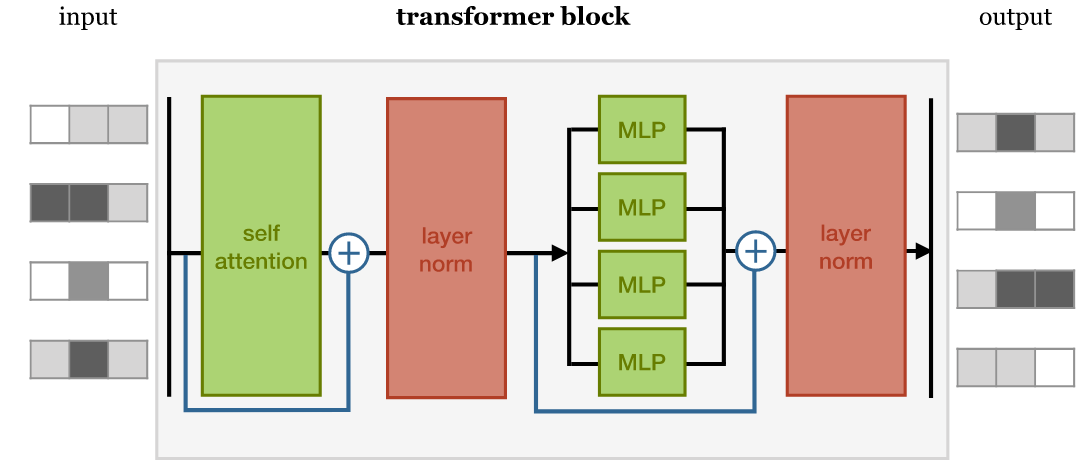

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0):
        super().__init__()
        self.attention = SelfAttention(emb, heads=heads, mask=mask)
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        ## Feed forward Network is given below : 
        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )
        self.do = nn.Dropout(dropout)

        ## For Layer Norm use nn.LayerNorm()
        ## For Drouput use nn.Dropout()
        ## Apply dropout after every layernorm (can you explain why this is done ??)
        
        ## Write your code here

    def forward(self, x):

        ## Write your code here
        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x

## Inferences and Conclusion : State all the key observations and conclusion

1. A simple transformer block using the self attention mechanism was designed.
2. The self attention model works by treating all the data points as vector. 
3. Every input vector 𝐱i is used in three different ways in the self attention operation:

  1. Query: It is compared to every other vector to establish the weights for its own output 𝐲i.
  2. Key: It is compared to every other vector to establish the weights for the output of the j-th vector 𝐲j.
  3. Value: It is used as part of the weighted sum to compute each output vector once the weights have been established.

It is used to handle sequence - to- sequence problems.
The transformes comprises of blocks of (in sequence): a self attention layer, layer normalization, a feed forward layer (a single MLP applied independently to each vector), and another layer normalization.

#**Problem 2** : Sentiment Analysis using Transformers



1. Consider IMDB sentiment classification dataset or any other sentiment classification datase (Twitter, Amazon food review), consider only Positive and Negative classes.
2. Preprocess the data using text preprocessing texhniques
3. Perform the classification task using the transformer block built earlier (Construct a Classification transformer using the transformer block built above) (Below Image shows the Classification transformer)
4. Report Test accuracy and confusion matrix


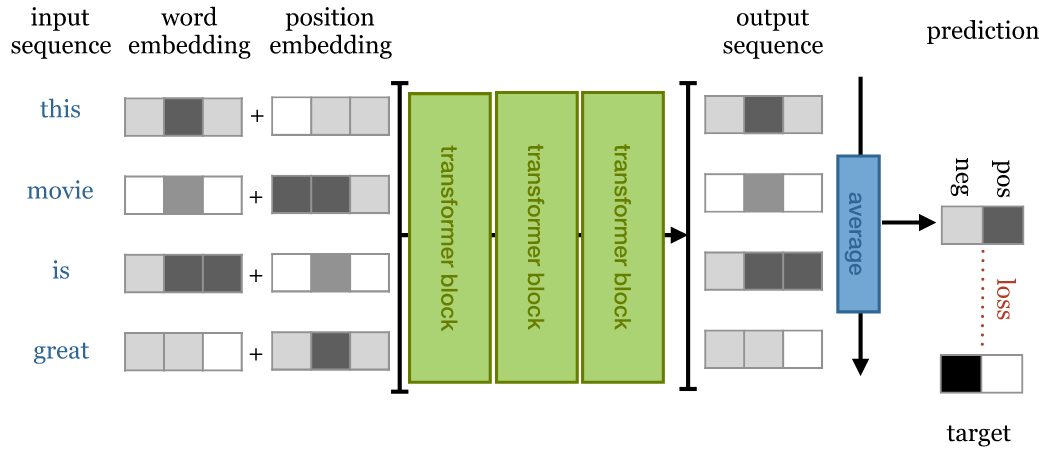

##Write down the Objectives, Hypothesis and Experimental description for the above problem


**Objective:** Perform classification task using a transformer.

**Hypothesis:** Transformers are used for sequential classification tasks and data comprising of time series analysis.

**Experimental description:**
1. IMDB and NLTK datasets are used for implementation via pytorch and keras respectively.
2. The observations are analyzed. 

## Programming : 
  Please write a program to demonstrate the same

**Use the following configurations as default, you can vary these and observe the performance** : 

1. Number of Attention Heads : 8
2. Number of Transformer Blocks : 6
3. Embedding Size : 128
4. Max Sequence Length : 512

**Classification Transformer Block**

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class CTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0, wide=False):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        ## Write your code here
        self.num_tokens, self.max_pool = num_tokens, max_pool

        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        self.unify_embeddings = nn.Linear(2 * emb, emb)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_classes)

        self.do = nn.Dropout(dropout)

        ## For token and positional embeddings use nn.Embedding() 

    def forward(self, x):

        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """

        ## Write your code here
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()

        positions = self.pos_embedding(torch.arange(t, device=d()))[None, :, :].expand(b, t, e)
        x = self.unify_embeddings(torch.cat((tokens, positions), dim=2).view(-1, 2 * e)).view(b, t, e)
        x = self.do(x)

        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension

        x = self.toprobs(x)

        return F.log_softmax(x, dim=1)




OPTIONS  Namespace(batch_size=8, depth=2, embedding_size=128, final=False, gradient_clipping=1.0, lr=0.001, lr_warmup=10000, max_length=512, max_pool=False, num_epochs=4, num_heads=8, seed=1, tb_dir='./runs', vocab_size=50000)
- nr. of training examples 2500
- nr. of validation examples 625

 epoch 0


100%|██████████| 2500/2500 [03:13<00:00, 12.94it/s]


-- validation accuracy 0.729

 epoch 1


100%|██████████| 2500/2500 [03:11<00:00, 13.02it/s]


-- validation accuracy 0.744

 epoch 2


100%|██████████| 2500/2500 [03:12<00:00, 12.98it/s]


-- validation accuracy 0.741

 epoch 3


100%|██████████| 2500/2500 [03:11<00:00, 13.07it/s]


-- validation accuracy 0.745


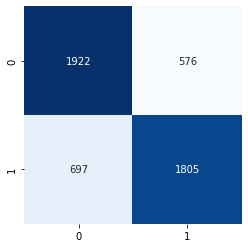

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

# from torchtext import data, datasets, vocab
from torchtext.legacy import data, datasets, vocab

import numpy as np

from argparse import ArgumentParser
from torch.utils.tensorboard import SummaryWriter

import random, tqdm, sys, math, gzip

# Used for converting between nats and bits
LOG2E = math.log2(math.e)
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)
NUM_CLS = 2

def go(arg):
    """
    Creates and trains a basic transformer for the IMDB sentiment classification task.
    """
    tbw = SummaryWriter(log_dir=arg.tb_dir) # Tensorboard logging

    # load the IMDB data
    if arg.final:
        train, test = datasets.IMDB.splits(TEXT, LABEL)

        TEXT.build_vocab(train, max_size=arg.vocab_size - 2)
        LABEL.build_vocab(train)

        train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=arg.batch_size, device=d())
    else:
        tdata, _ = datasets.IMDB.splits(TEXT, LABEL)
        train, test = tdata.split(split_ratio=0.8)

        TEXT.build_vocab(train, max_size=arg.vocab_size - 2) # - 2 to make space for <unk> and <pad>
        LABEL.build_vocab(train)

        train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=arg.batch_size, device=d())

    print(f'- nr. of training examples {len(train_iter)}')
    print(f'- nr. of {"test" if arg.final else "validation"} examples {len(test_iter)}')

    if arg.max_length < 0:
        mx = max([input.text[0].size(1) for input in train_iter])
        mx = mx * 2
        print(f'- maximum sequence length: {mx}')
    else:
        mx = arg.max_length

    # create the model
    model = CTransformer(emb=arg.embedding_size, heads=arg.num_heads, depth=arg.depth, seq_length=mx, num_tokens=arg.vocab_size, num_classes=NUM_CLS, max_pool=arg.max_pool)
    if torch.cuda.is_available():
        model.cuda()

    opt = torch.optim.Adam(lr=arg.lr, params=model.parameters())
    sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (arg.lr_warmup / arg.batch_size), 1.0))

    # training loop
    seen = 0
    for e in range(arg.num_epochs):

        print(f'\n epoch {e}')
        model.train(True)

        for batch in tqdm.tqdm(train_iter):

            opt.zero_grad()

            input = batch.text[0]
            label = batch.label - 1

            if input.size(1) > mx:
                input = input[:, :mx]
            out = model(input)
            loss = F.nll_loss(out, label)

            loss.backward()

            # clip gradients
            # - If the total gradient vector has a length > 1, we clip it back down to 1.
            if arg.gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), arg.gradient_clipping)

            opt.step()
            sch.step()

            seen += input.size(0)
            tbw.add_scalar('classification/train-loss', float(loss.item()), seen)

        with torch.no_grad():

            model.train(False)
            tot, cor= 0.0, 0.0
            test_labels = []
            pred = []
            for batch in test_iter:

                input = batch.text[0]
                label = batch.label - 1
                labels = np.array(label.cpu())
                test_labels.append(labels)
                if input.size(1) > mx:
                    input = input[:, :mx]
                out = model(input).argmax(dim=1)
                preds = np.array(out.cpu())
                pred.append(preds)
                tot += float(input.size(0))
                cor += float((label == out).sum().item())

            acc = cor / tot
            print(f'-- {"test" if arg.final else "validation"} accuracy {acc:.3}')
            tbw.add_scalar('classification/test-loss', float(loss.item()), e)
    matrix_confusion = confusion_matrix(np.concatenate(test_labels), np.concatenate(pred))
    sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
    #df_confusion = pd.crosstab(y_val, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

import sys
sys.argv=['']
del sys
if __name__ == "__main__":

    parser = ArgumentParser()

    parser.add_argument("-e", "--num-epochs",
                        dest="num_epochs",
                        help="Number of epochs.",
                        default=4, type=int)

    parser.add_argument("-b", "--batch-size",
                        dest="batch_size",
                        help="The batch size.",
                        default=8, type=int)

    parser.add_argument("-l", "--learn-rate",
                        dest="lr",
                        help="Learning rate",
                        default=0.001, type=float)

    parser.add_argument("-T", "--tb_dir", dest="tb_dir",
                        help="Tensorboard logging directory",
                        default='./runs')

    parser.add_argument("-f", "--final", dest="final",
                        help="Whether to run on the real test set (if not included, the validation set is used).",
                        action="store_true")

    parser.add_argument("--max-pool", dest="max_pool",
                        help="Use max pooling in the final classification layer.",
                        action="store_true")

    parser.add_argument("-E", "--embedding", dest="embedding_size",
                        help="Size of the character embeddings.",
                        default=128, type=int)

    parser.add_argument("-V", "--vocab-size", dest="vocab_size",
                        help="Number of words in the vocabulary.",
                        default=50_000, type=int)

    parser.add_argument("-M", "--max", dest="max_length",
                        help="Max sequence length. Longer sequences are clipped (-1 for no limit).",
                        default=512, type=int)

    parser.add_argument("-H", "--heads", dest="num_heads",
                        help="Number of attention heads.",
                        default=8, type=int)

    parser.add_argument("-d", "--depth", dest="depth",
                        help="Depth of the network (nr. of self-attention layers)",
                        default=2, type=int)

    parser.add_argument("-r", "--random-seed",
                        dest="seed",
                        help="RNG seed. Negative for random",
                        default=1, type=int)

    parser.add_argument("--lr-warmup",
                        dest="lr_warmup",
                        help="Learning rate warmup.",
                        default=10_000, type=int)

    parser.add_argument("--gradient-clipping",
                        dest="gradient_clipping",
                        help="Gradient clipping.",
                        default=1.0, type=float)

    options = parser.parse_args()

    print('OPTIONS ', options)

    go(options)

## Inferences and Conclusion : State all the key observations and conclusion

On training our model with the IMDB dataset we got a validation accuracy of around 75%.
The accuracy can be futher improved by increasing the number of epochs, decreasing the depth of model and decreasing the batch size as was observed.

**NLTK dataset**

Procedures:
- Load the corpus texts (`nltk.corpus.movie_reviews`)
- Build the keras `tokenizer()`
- Fit the `tokenizer` on the corpus texts
- Convert the word sequences of texts into integer sentences with the `tokenizer`
- Pad input lengths to uniform sizes

In [ ]:
import nltk, random
import numpy as np
from nltk.corpus import movie_reviews
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,key_dim=embed_dim)
        #self.att = SelfAttention(embed_dim, heads=num_heads)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)  # self-attention layer
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # layer norm
        ffn_output = self.ffn(out1)  #feed-forward layer
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # layer norm

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
import nltk
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [ ]:
## loading corpus
documents = [(' '.join(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)  #in-place shuffle

In [ ]:
print('Number of Reviews/Documents: {}'.format(len(documents)))
print('Sample Text of Doc 1:')
print('-' * 30)
print(documents[0][0][:50])  # first 50 words of the first document

Number of Reviews/Documents: 2000
Sample Text of Doc 1:
------------------------------
capsule : combine one quart of raiders of the lost


In [ ]:
## Train-Test Split
train_set, test_set = train_test_split(documents, test_size=0.1, random_state=42)

In [ ]:
## Hyperparameters fot tokenizer
vocab_size = 10000
maxlen = 512  # Only consider the last 200 words of each movie review

## texts vs. labels
texts = np.array([t for (t, l) in train_set])
labels = np.array([1 if l == 'pos' else 0 for (t, l) in train_set])
## tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
## fit tokenizer
tokenizer.fit_on_texts(texts)
## text to sequences
texts_to_int = tokenizer.texts_to_sequences(texts)
## pad sequences
texts_to_int_pad = keras.preprocessing.sequence.pad_sequences(texts_to_int,
                                                              maxlen=maxlen,
                                                              truncating='pre',
                                                              padding='pre')

In [ ]:
## X and y for train and val
x_train = texts_to_int_pad
y_train = labels


## Perform same vectorization on testing set
x_val_text = np.array([t for (t,l) in test_set])

x_val = keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(x_val_text),
    maxlen=maxlen,
    truncating='pre',
    padding='pre'
)
    
y_val = np.array([1 if l == 'pos' else 0 for (t, l) in test_set])

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1800, 512)
(1800,)
(200, 512)
(200,)


In [ ]:
# Check Total Vocab Size
total_vocab_size = len(tokenizer.word_index) + 1
print('Total Vocabulary Size (Untrimmed): %d' % total_vocab_size)
print('Vocabulary Size (trimmed): %d' % vocab_size)

Total Vocabulary Size (Untrimmed): 37872
Vocabulary Size (trimmed): 10000


In [ ]:
embed_dim = 128  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

## Using Sequential API
model = keras.Sequential()
model.add(layers.Input(shape=(maxlen, )))
model.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
model.add(TransformerBlock(embed_dim, num_heads, ff_dim))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(ff_dim, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

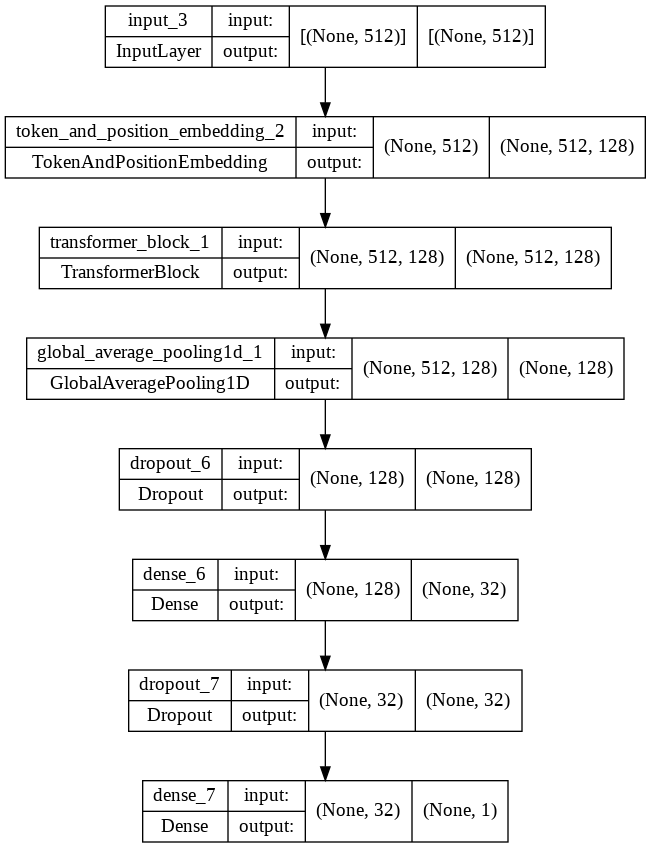

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
29/29 [==============================] - 15s 397ms/step - loss: 0.7084 - accuracy: 0.5044 - val_loss: 0.6825 - val_accuracy: 0.5550
Epoch 2/10
29/29 [==============================] - 11s 387ms/step - loss: 0.6638 - accuracy: 0.5906 - val_loss: 0.5744 - val_accuracy: 0.7500
Epoch 3/10
29/29 [==============================] - 11s 390ms/step - loss: 0.4005 - accuracy: 0.8217 - val_loss: 0.3685 - val_accuracy: 0.8650
Epoch 4/10
29/29 [==============================] - 11s 387ms/step - loss: 0.1331 - accuracy: 0.9511 - val_loss: 0.4394 - val_accuracy: 0.8800
Epoch 5/10
29/29 [==============================] - 11s 388ms/step - loss: 0.0513 - accuracy: 0.9828 - val_loss: 0.5280 - val_accuracy: 0.8600
Epoch 6/10
29/29 [==============================] - 11s 389ms/step - loss: 0.0372 - accuracy: 0.9867 - val_loss: 0.5522 - val_accuracy: 0.8350
Epoch 7/10
29/29 [==============================] - 11s 390ms/step - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.7201 - val_accuracy: 0.8550

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150


# Plotting results
def plot1(history):
    acc = history.history['accuracy']
    plt.figure(figsize=(3,3))
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure(figsize=(3,3))

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(3,3))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

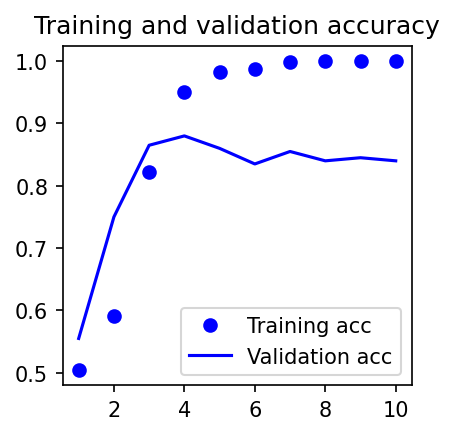

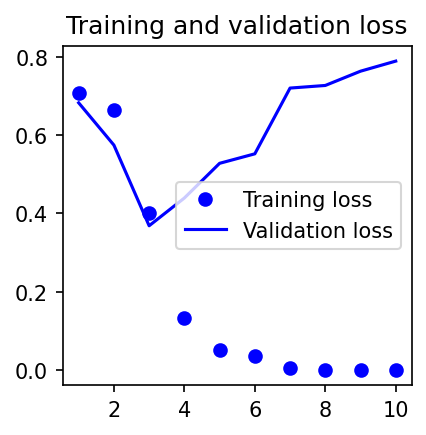

In [ ]:
plot1(history)

In [ ]:
pred = np.round(model.predict(x_val))

In [ ]:
y_val

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1])

In [ ]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']
test = keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(pred_sentences),
    maxlen=maxlen,
    truncating='pre',
    padding='pre'
)

In [ ]:
test.shape

(2, 512)

In [ ]:
pred = model.predict(test)
pred

array([[0.05745607],
       [0.01083959]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

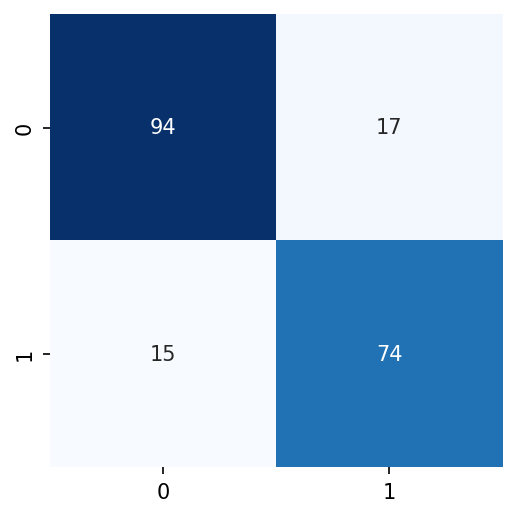

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
matrix_confusion = confusion_matrix(y_val, pred)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
#df_confusion = pd.crosstab(y_val, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

# **Inference and Conclusion**

1. On training with NLTK data the validation loss values are not converging as can be seen from the graph.
2. The validation loss can be improved by changing the batch size, increasing the epochs, changing embedding dimensions. 
3. Including more dropouts, regularization, and normalization.